In [5]:
#### 6.2.TumorOnly_Cor.merged.V8.CV2500.cor.Scaled2s_Robust_test.rmN.R
### 1.Loading data
## 1)
Tumor.Cor.merged.V8.CV2500.scaled.Twice.dataset <- readRDS("/data8t_4/JH/MyJobs/COAD_NormalCancer_Project/5_My_method_evaluation/Tumor.Cor.merged.V8.CV2500.scaled.Twice.dataset.rds")
Trans.Rang1.CV2500.Normalized.tumor <- Tumor.Cor.merged.V8.CV2500.scaled.Twice.dataset$Trans.Rang1.CV2500.Normalized.tumor
COAD.pheno.tumor <- Tumor.Cor.merged.V8.CV2500.scaled.Twice.dataset$COAD.pheno.tumor
## 2)Loading cluster results
Cluster.20200201.V7.Tumor <- readRDS("/data8t_4/JH/MyJobs/NormalCancer_TCGA_V2/Cluster.20200201.V7.Tumor.rds")
cutree.res <- Cluster.20200201.V7.Tumor$cutree.res
dynamicColors <- Cluster.20200201.V7.Tumor$dynamicColors
Cluster.df <- cbind(cutree.res,dynamicColors) 
Cluster.df <- as.data.frame(Cluster.df)
Cluster.df$rownames <- rownames(Cluster.df)
table(Cluster.df$dynamicColors)


     blue     brown turquoise    yellow 
      103        47       135         1 

  cluster size ave.sil.width
1       1  103          0.12
2       2   47          0.20
3       3  135          0.14
4       4    1          0.00


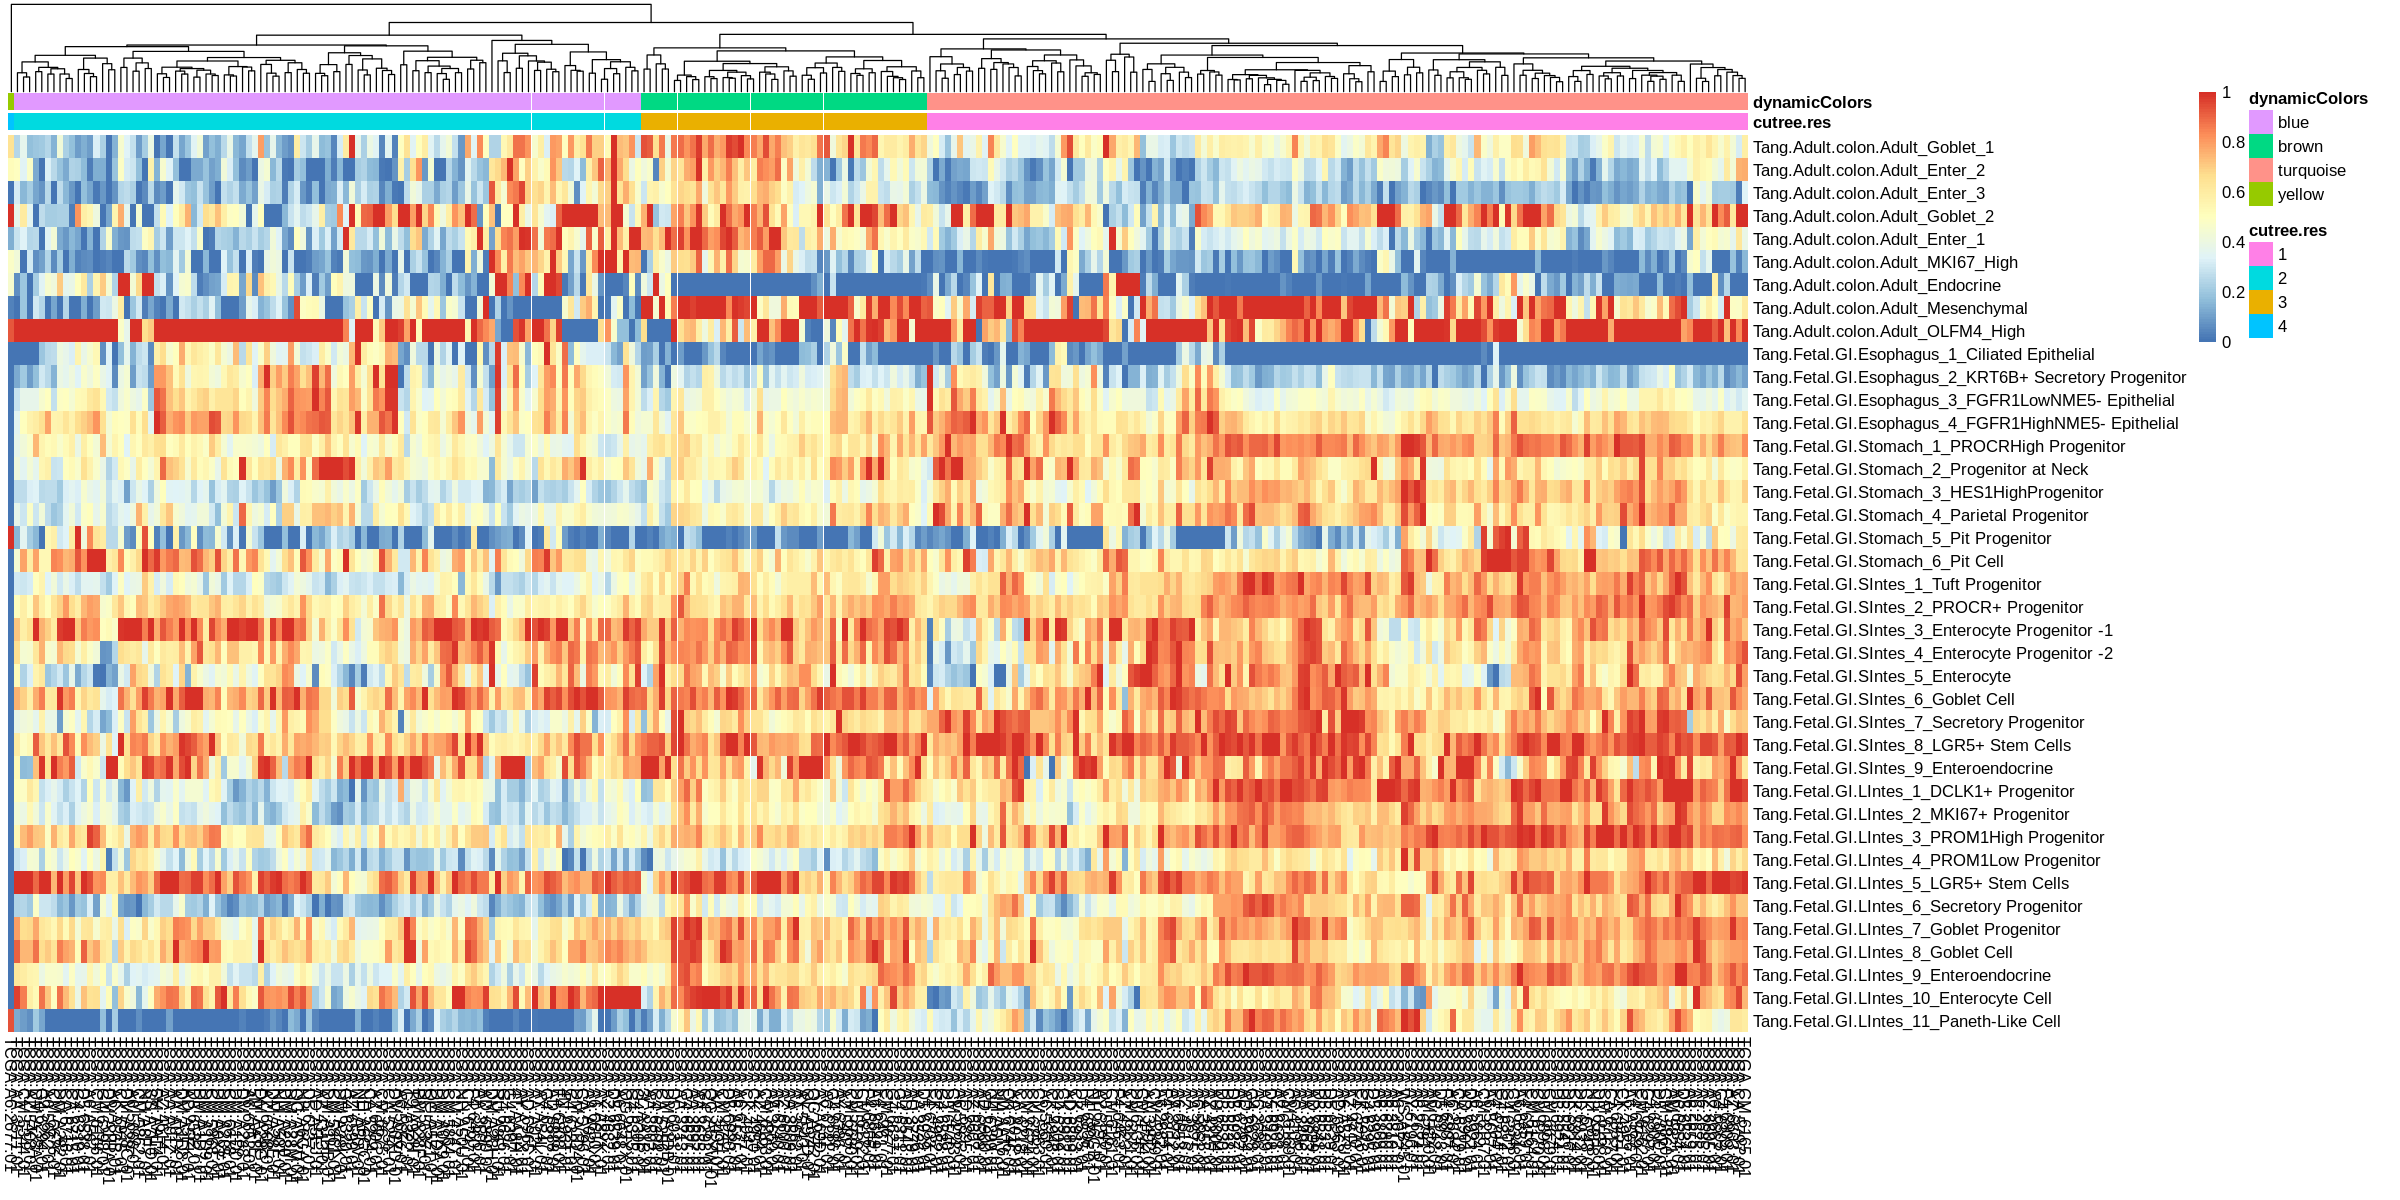

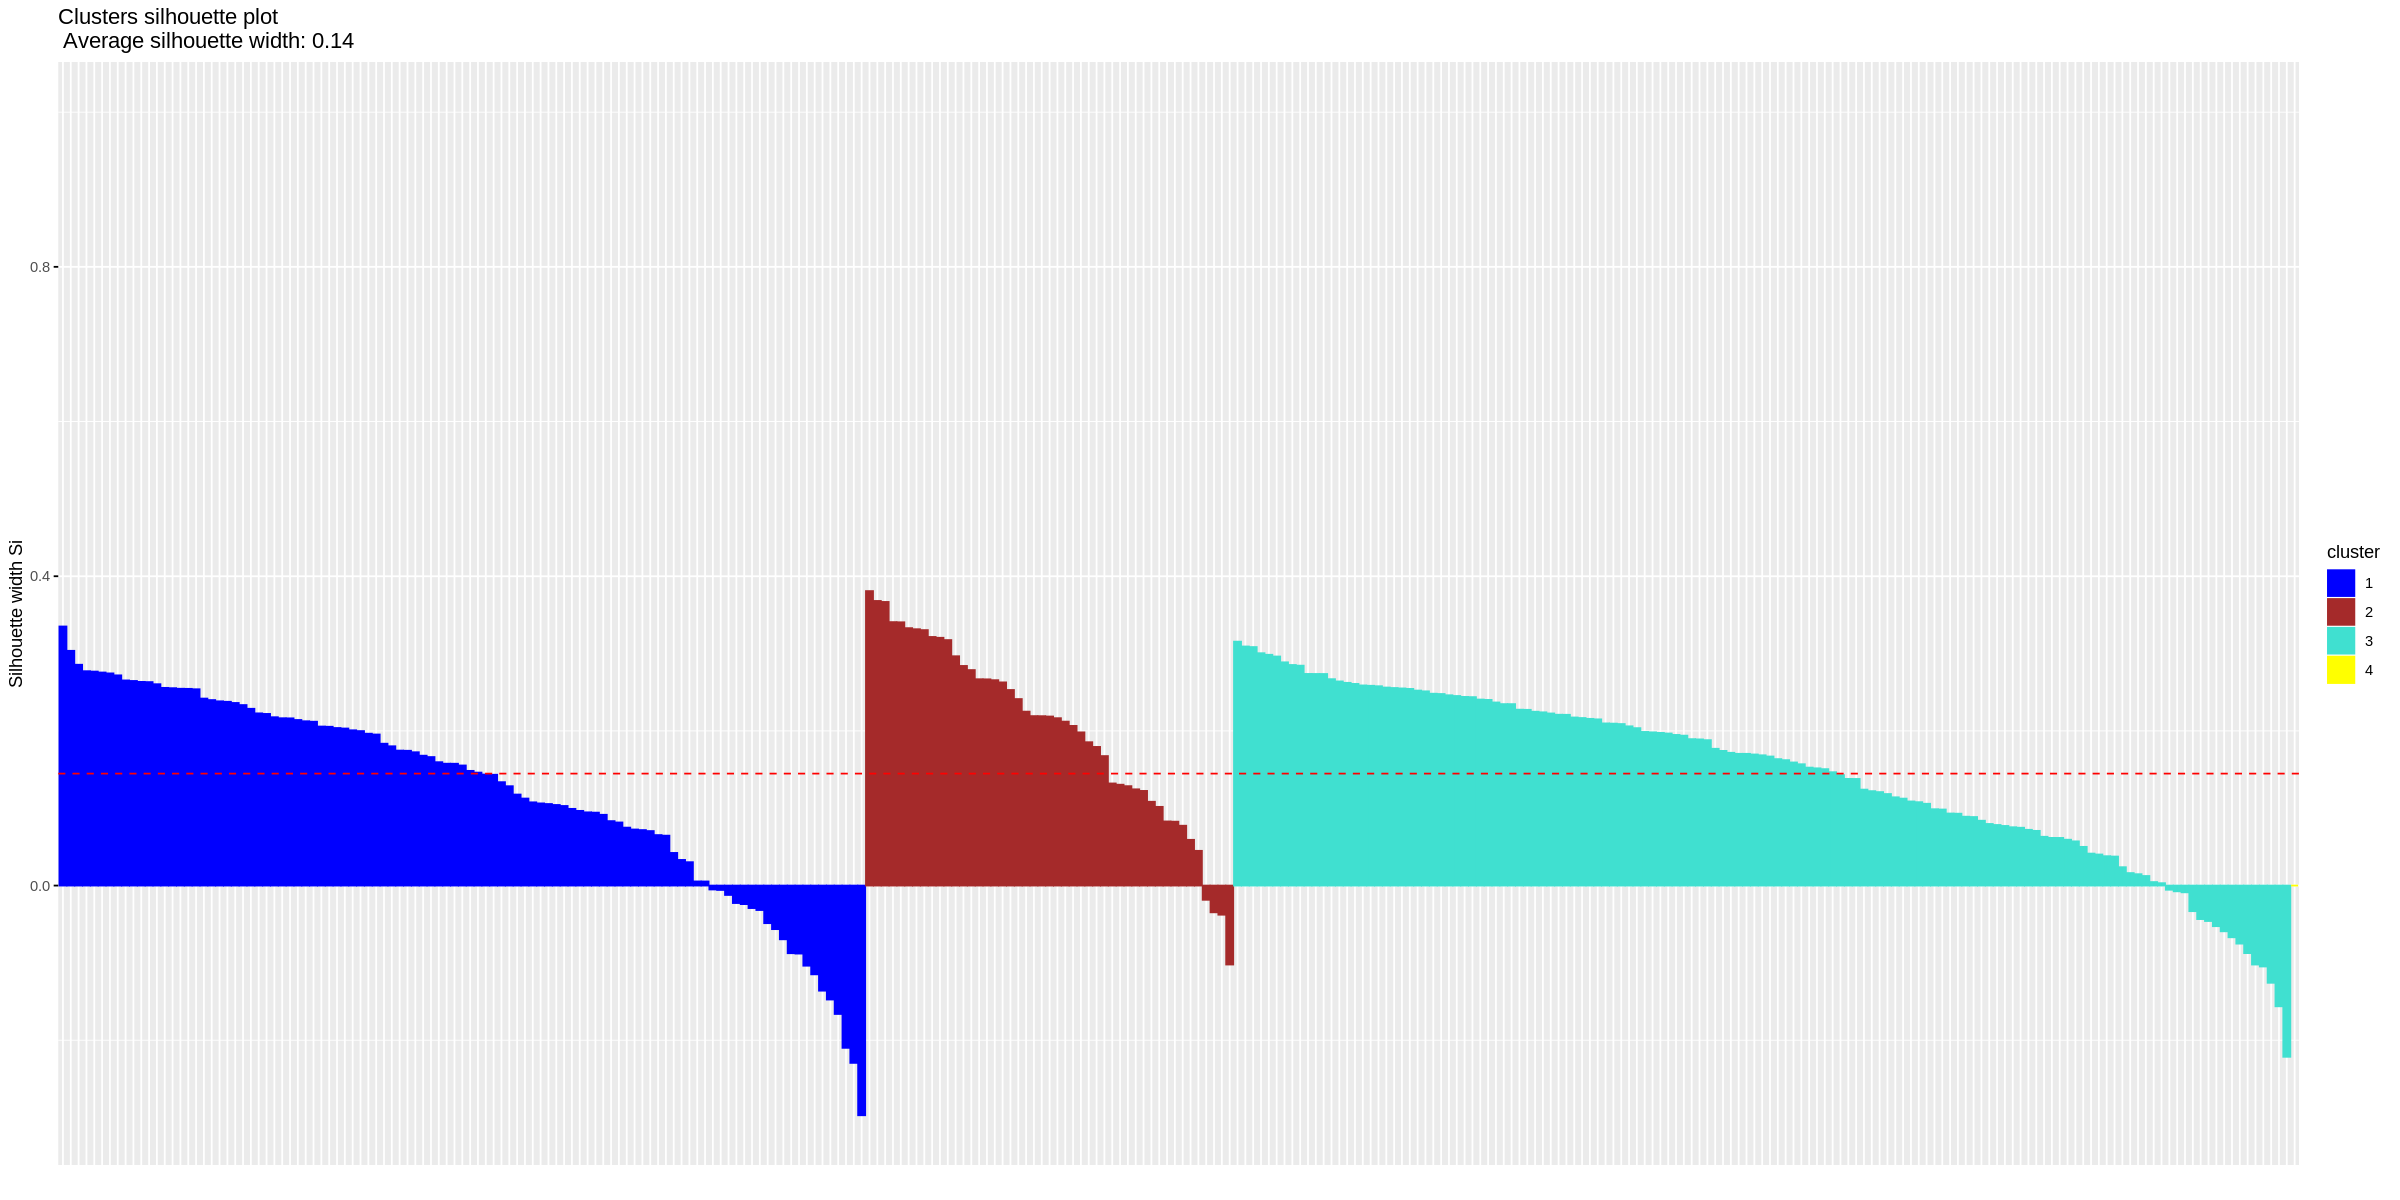

In [12]:
### 2.Prepare group labels
Trans.Rang1.CV2500.Normalized.tumor.ordered <- Trans.Rang1.CV2500.Normalized.tumor[,Cluster.df$rownames]
ClusterRes <- as.numeric(Cluster.df$dynamicColors)
pheatmap::pheatmap(Trans.Rang1.CV2500.Normalized.tumor.ordered,cluster_rows = F,
                   annotation_col = Cluster.df[,-3])

## original results ##
require("cluster")
Trans.Rang1.CV2500.Normalized.tumor.ordered.dist <- dist(t(Trans.Rang1.CV2500.Normalized.tumor.ordered), method="euclidean")
sil <- silhouette(ClusterRes, Trans.Rang1.CV2500.Normalized.tumor.ordered.dist)
library(factoextra)
options(repr.plot.width=20, repr.plot.height=10)
fviz_silhouette(sil,palette = c("blue", "brown", "turquoise", "yellow"))


In [7]:
### 3.remove N items
rmN.list <-  list()
# x was remove how many reference cell types
Trans.Rang1_tb <- Trans.Rang1.CV2500.Normalized.tumor.ordered
cellTypesName <- rownames(Trans.Rang1_tb)
for(x in 1:37){
  # x=10
  ### generate 50 smaple sets
  #cx <- list()
  ## generate sampling m times N samples
  m = 100
  cx <- lapply(1:m, function(j){
    #print(j)
    sample(cellTypesName, x)
  })
  ## remove 2 items
  si.average <- list()
  for(i in 1:m ){
    # i=1
    rmCellTypes <- cx[[i]]
    # remove cellTypes
    Trans.Rang1_tb_sub <- Trans.Rang1_tb[!rownames(Trans.Rang1_tb) %in% rmCellTypes,]
    Trans.Rang1_tb_sub.dist <- dist(t(Trans.Rang1_tb_sub), method="euclidean")
    require("cluster")
    sil.merge <- silhouette(ClusterRes, Trans.Rang1_tb_sub.dist)
    si.average[[i]] <- summary(sil.merge)$clus.avg.widths
    #COAD.pheno_sub <- as.data.frame(COAD.pheno[,c("sampleTypes","msi")])
    #pheatmap::pheatmap(Trans.Rang1.CV2500.Normalized_sub, 
    #                   annotation_col = COAD.pheno_sub,
    #                   cluster_rows = F)
  }
  si.average.tb <- do.call(rbind,si.average)
  si.average.tb <- as.data.frame(si.average.tb)
  si.average.tb$rmNum <- rep(x,length(cx))
  rmN.list[[x]] <- si.average.tb
  
}

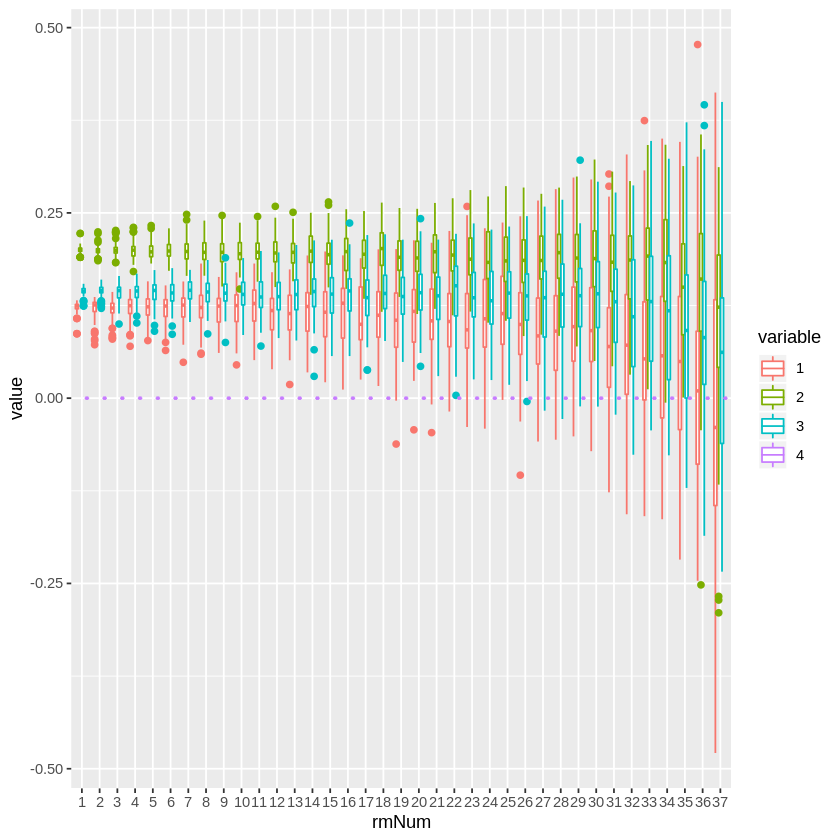

In [8]:
si.average.rmN.table <- do.call(rbind,rmN.list)
### plot ggplot
library(ggplot2)
library(reshape2)
plotData <- melt(si.average.rmN.table,id.vars = 5)
#ggplot(si.average.rmN.table) 
plotData$rmNum <- as.factor(plotData$rmNum)
ggplot(plotData) + geom_boxplot(aes(x=rmNum, y=value, color=variable))


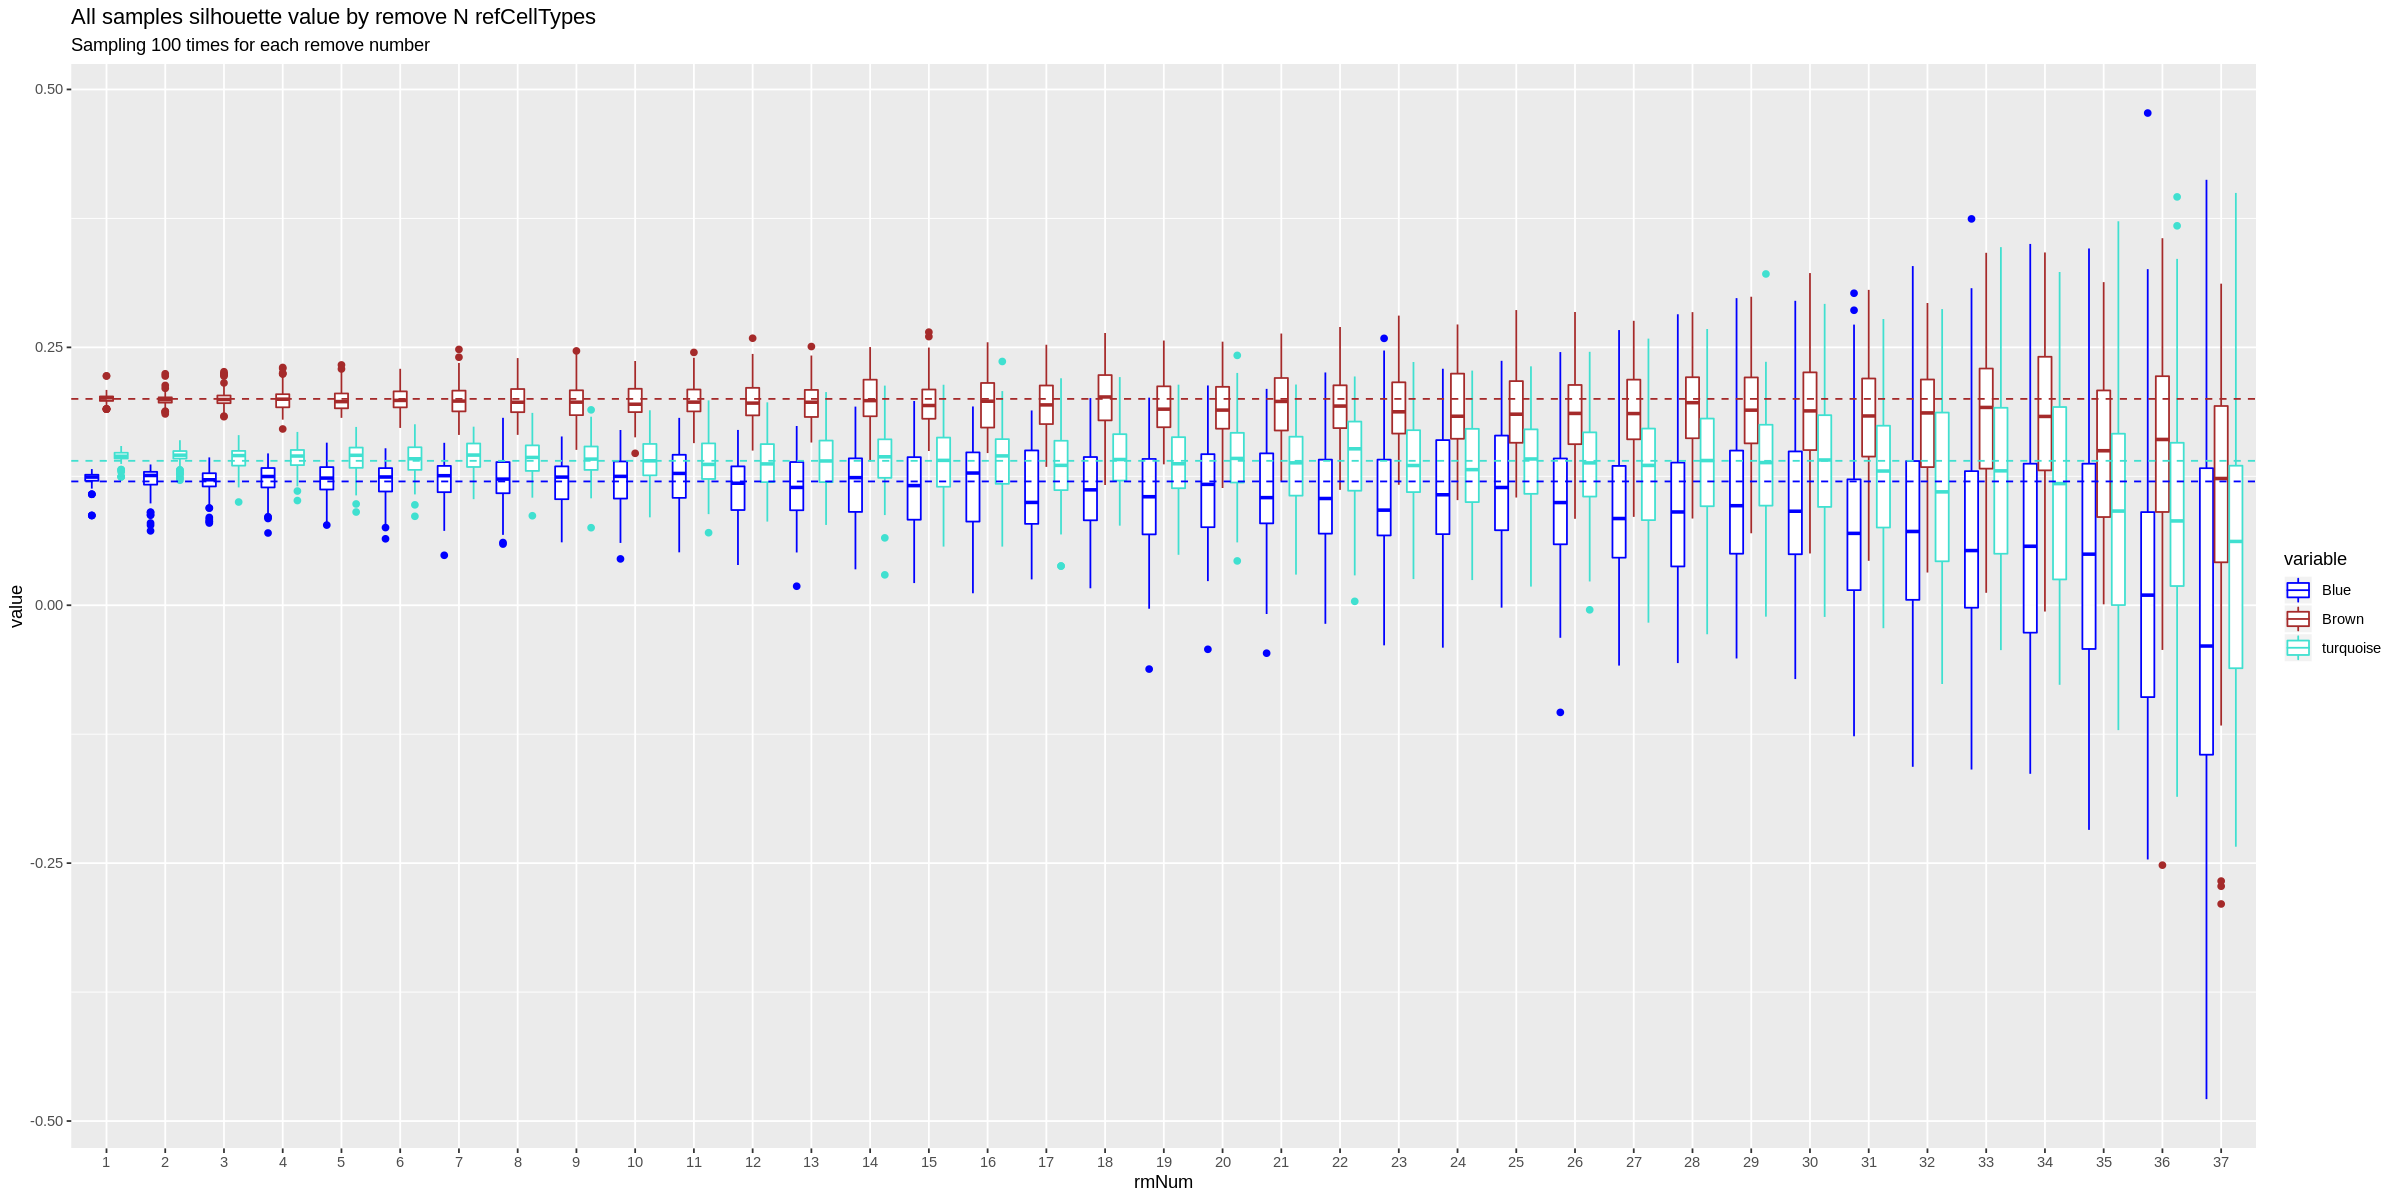

In [11]:
### Clean plot 
si.average.rmN.table <- do.call(rbind,rmN.list)
si.average.rmN.table.clean <- si.average.rmN.table[,-4]
colnames(si.average.rmN.table.clean) <- c("Blue", "Brown","turquoise","rmNum")
plotData.clean <- melt(si.average.rmN.table.clean,id.vars = 4)
plotData.clean$rmNum <- as.factor(plotData.clean$rmNum)
options(repr.plot.width=20, repr.plot.height=10)
ggplot(plotData.clean) + geom_boxplot(aes(x=rmNum, y=value, color=variable))+
  labs(title = "All samples silhouette value by remove N refCellTypes",subtitle = paste("Sampling", m, "times for each remove number")) +
  scale_color_manual(values= c("blue","brown","turquoise","yellow"))+
  geom_hline(yintercept=0.12, linetype="dashed", color = "blue")+
  geom_hline(yintercept=0.20, linetype="dashed", color = "brown")+
  geom_hline(yintercept=0.14, linetype="dashed", color = "turquoise")

